In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

In [ ]:
# Load dataset and prepare basic types
import pandas as pd
import numpy as np

INPUT_FILE = "/content/drive/MyDrive/WI-DR/widr_zone_day_integrated_2021_2023.csv"
OUT_FILE   = "/content/drive/MyDrive/WI-DR/widr_zone_day_model_ready_2021_2023.csv"

df = pd.read_csv(INPUT_FILE)

# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

# Ensure zone_id is clean text
df["zone_id"] = df["zone_id"].astype(str).str.strip()

# Show columns to confirm dataset structure
print("Columns:", df.columns.tolist())



Columns: ['date', 'zone_id', 'zone_name', 'population', 'waste_baseline_tons', 'dow', 'month', 'is_umuganda', 'event_count_cal', 'event_intensity_cal', 'rain_mm', 'temp_c', 'humidity', 'ndvi']


# **Data Preprocessing**  

The preprocessing stage prepared the integrated zone–day dataset for modeling by ensuring data consistency, completeness, and temporal alignment. Missing values in event-related variables were replaced with zero to represent absence of events, while NDVI values were forward and backward filled within each zone due to their slow temporal variation. Weather variables were completed using daily median imputation followed by forward and backward filling to avoid discontinuities. The dataset was sorted by zone and date to preserve time-series order, and duplicate records were removed. This step ensured a clean, continuous, and reliable dataset suitable for time-series forecasting.

In [ ]:
# Check for duplicate zone_id + date rows
dups = df.duplicated(["zone_id", "date"]).sum()
print("Duplicate (zone_id,date) rows:", dups)

# Sort dataset by zone and time
df = df.sort_values(["zone_id", "date"]).reset_index(drop=True)
print("Date range:", df["date"].min(), "->", df["date"].max())

# Columns used for preprocessing
EVENT_COLS   = ["is_holiday", "is_umuganda", "event_count_cal", "event_intensity_cal"]
WEATHER_COLS = ["rain_mm", "temp_c", "humidity"]

# Fill missing event values with 0
for c in EVENT_COLS:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# NDVI is slow-changing → forward/back fill within each zone
if "ndvi" in df.columns:
    df["ndvi"] = df.groupby("zone_id")["ndvi"].ffill().bfill()

# Weather fill: use median per date, then forward/back fill
for c in WEATHER_COLS:
    if c in df.columns:
        df[c] = df[c].fillna(df.groupby("date")[c].transform("median"))
        df[c] = df[c].ffill().bfill()

# Show missing percentage
print("\nMissing % (top columns):")
print((df.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))


Duplicate (zone_id,date) rows: 0
Date range: 2021-01-01 00:00:00 -> 2023-12-31 00:00:00

Missing % (top columns):
date                   0.0
zone_id                0.0
zone_name              0.0
population             0.0
waste_baseline_tons    0.0
dow                    0.0
month                  0.0
is_umuganda            0.0
event_count_cal        0.0
event_intensity_cal    0.0
dtype: float64


In [ ]:
# Generate realistic daily waste from baseline using seasonality, events, weather and noise
np.random.seed(42)

# Ensure time columns exist
df["month"] = df["date"].dt.month
df["dow"]   = df["date"].dt.dayofweek

# Monthly seasonality
month_factor = {1:1.02,2:0.98,3:1.00,4:1.03,5:1.05,6:1.02,7:1.04,8:1.06,9:1.03,10:1.05,11:1.07,12:1.10}
df["season_month"] = df["month"].map(month_factor)

# Weekly pattern (weekends slightly higher waste)
weekday_factor = {0:0.98,1:1.00,2:1.01,3:1.02,4:1.03,5:1.07,6:1.06}
df["season_week"] = df["dow"].map(weekday_factor)

# Event effects (events slightly change waste)
df["event_factor"] = 1.0
if "event_intensity_cal" in df.columns:
    df["event_factor"] += np.clip(df["event_intensity_cal"] * 0.02, -0.10, 0.15)
if "is_umuganda" in df.columns:
    df.loc[df["is_umuganda"] == 1, "event_factor"] -= 0.15  # cleanup day reduces waste

# Weather effects
df["weather_factor"] = 1.0
if "rain_mm" in df.columns:
    df["weather_factor"] += np.clip(df["rain_mm"] / 200, -0.05, 0.05)
if "temp_c" in df.columns:
    df["weather_factor"] += np.clip((df["temp_c"] - 22) / 100, -0.03, 0.03)

# NDVI seasonal effect
df["ndvi_factor"] = 1.0
if "ndvi" in df.columns:
    ndvi_z = (df["ndvi"] - df["ndvi"].mean()) / (df["ndvi"].std() + 1e-9)
    df["ndvi_factor"] += np.clip(ndvi_z * 0.02, -0.03, 0.03)

# Small random natural variation
noise = np.random.normal(0, 0.03, len(df))

# Final DAILY waste
df["waste_tons_day"] = (
    df["waste_baseline_tons"]
    * df["season_month"]
    * df["season_week"]
    * df["event_factor"]
    * df["weather_factor"]
    * df["ndvi_factor"]
    * (1 + noise)
).clip(lower=0)

# Quick check
print(df[["zone_id","date","waste_baseline_tons","waste_tons_day"]].head(10))
print("Daily waste std:", df.groupby("zone_id")["waste_tons_day"].std().mean())


  zone_id       date  waste_baseline_tons  waste_tons_day
0  SEC_01 2021-01-01             14.93408       18.571184
1  SEC_01 2021-01-02             14.93408       18.893238
2  SEC_01 2021-01-03             14.93408       15.925679
3  SEC_01 2021-01-04             14.93408       17.457542
4  SEC_01 2021-01-05             14.93408       14.844465
5  SEC_01 2021-01-06             14.93408       14.932279
6  SEC_01 2021-01-07             14.93408       15.946664
7  SEC_01 2021-01-08             14.93408       15.951568
8  SEC_01 2021-01-09             14.93408       16.249034
9  SEC_01 2021-01-10             14.93408       16.519607
Daily waste std: 1.8825958034773351


In [ ]:
# Set target column for modeling
TARGET = "waste_tons_day"
# Confirm it exists
print("TARGET exists?", TARGET in df.columns)


TARGET exists? True


# **Feature Engineering**

Feature engineering transformed the raw dataset into a predictive time-series modeling dataset. Time-based features such as month, day of week, weekend indicator, and week of year were extracted to capture temporal waste patterns. Cyclical encoding was applied to represent periodic time behavior. Lag features (1, 7, 14, and 28 days) were created to provide temporal memory of past waste generation, while rolling averages captured underlying demand trends and reduced noise. Environmental and contextual signals including weather, NDVI, and community events (e.g., Umuganda) were incorporated to model external influences on waste generation. All features were constructed using only past data to prevent data leakage, ensuring valid forecasting performance.

In [ ]:
# Time features
d = df["date"]
df["year"] = d.dt.year
df["month"] = d.dt.month
df["day"] = d.dt.day
df["dow"] = d.dt.dayofweek
df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
df["weekofyear"] = d.dt.isocalendar().week.astype(int)

# Cyclical encoding
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
df["dow_sin"]   = np.sin(2 * np.pi * df["dow"] / 7)
df["dow_cos"]   = np.cos(2 * np.pi * df["dow"] / 7)

# Lag and rolling features
LAGS = [1, 7, 14, 28]
ROLL_WINDOWS = [7, 14, 28]

g = df.groupby("zone_id")[TARGET]

# Target lags
for lag in LAGS:
    df[f"{TARGET}_lag{lag}"] = g.shift(lag)

# Target rolling
shifted = g.shift(1)
for w in ROLL_WINDOWS:
    df[f"{TARGET}_roll{w}_mean"] = (
        shifted.groupby(df["zone_id"])
               .rolling(w, min_periods=w)
               .mean()
               .reset_index(level=0, drop=True)
    )

# NDVI lags/rolling
if "ndvi" in df.columns:
    ng = df.groupby("zone_id")["ndvi"]

    for lag in [1, 7, 14]:
        df[f"ndvi_lag{lag}"] = ng.shift(lag)

    ndvi_shifted = ng.shift(1)
    for w in ROLL_WINDOWS:
        df[f"ndvi_roll{w}_mean"] = (
            ndvi_shifted.groupby(df["zone_id"])
                        .rolling(w, min_periods=w)
                        .mean()
                        .reset_index(level=0, drop=True)
        )

# Preview check
print(df[["zone_id", "date", TARGET, f"{TARGET}_lag1", f"{TARGET}_roll7_mean"]].head(15))

# Drop early rows where full lag/rolling not available
df_model = df.dropna(subset=[f"{TARGET}_lag28", f"{TARGET}_roll28_mean"]).copy()

# Save model-ready dataset
df_model.to_csv(OUT_FILE, index=False)

print("Saved:", OUT_FILE)
print("Shape:", df_model.shape)
print("Zones:", df_model["zone_id"].nunique())
print("Date range:", df_model["date"].min(), "->", df_model["date"].max())


   zone_id       date  waste_tons_day  waste_tons_day_lag1  \
0   SEC_01 2021-01-01       18.571184                  NaN   
1   SEC_01 2021-01-02       18.893238            18.571184   
2   SEC_01 2021-01-03       15.925679            18.893238   
3   SEC_01 2021-01-04       17.457542            15.925679   
4   SEC_01 2021-01-05       14.844465            17.457542   
5   SEC_01 2021-01-06       14.932279            14.844465   
6   SEC_01 2021-01-07       15.946664            14.932279   
7   SEC_01 2021-01-08       15.951568            15.946664   
8   SEC_01 2021-01-09       16.249034            15.951568   
9   SEC_01 2021-01-10       16.519607            16.249034   
10  SEC_01 2021-01-11       14.899643            16.519607   
11  SEC_01 2021-01-12       14.599014            14.899643   
12  SEC_01 2021-01-13       15.200887            14.599014   
13  SEC_01 2021-01-14       14.823757            15.200887   
14  SEC_01 2021-01-15       15.058827            14.823757   

    was

# **Data Visualization**

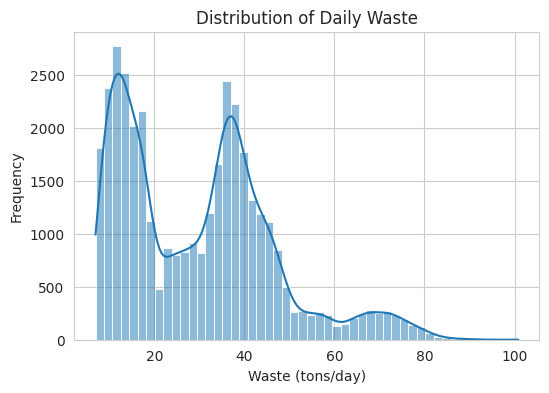

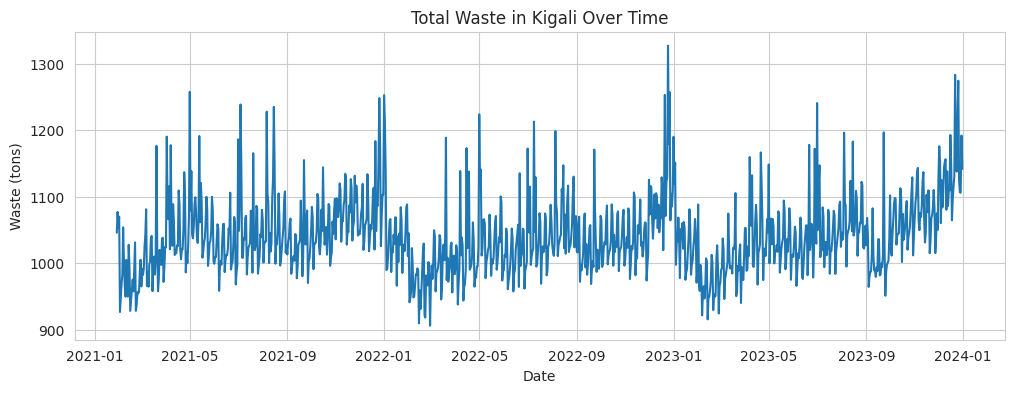

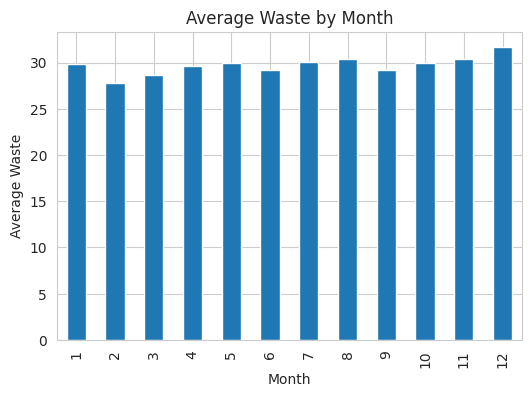

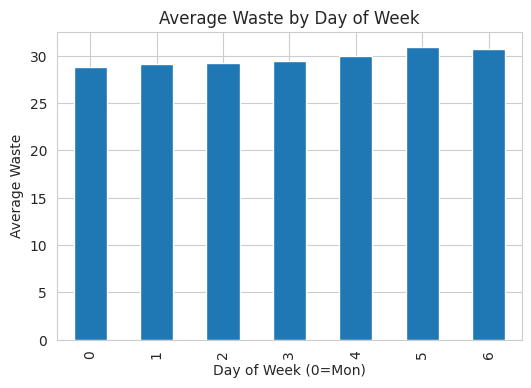

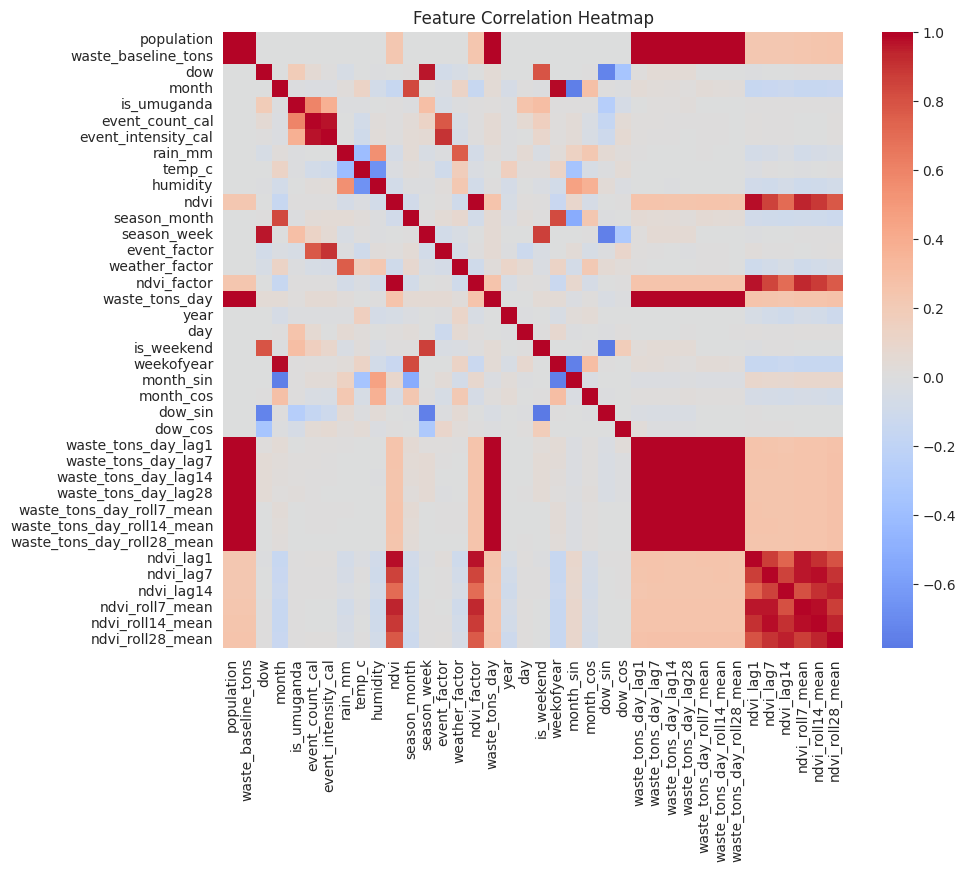

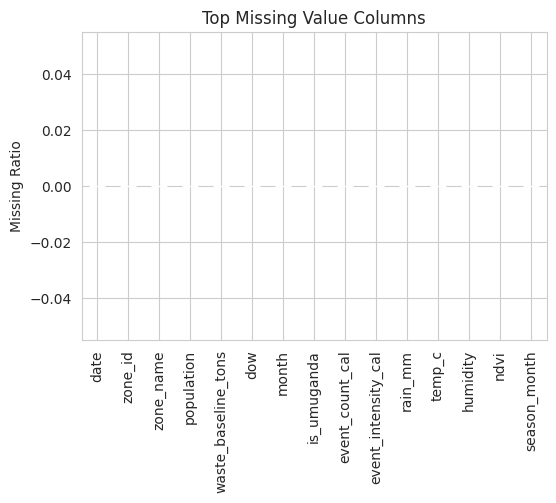

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Target distribution
plt.figure(figsize=(6,4))
sns.histplot(df_model["waste_tons_day"], bins=50, kde=True)
plt.title("Distribution of Daily Waste Across Zones")
plt.xlabel("Waste (tons/day)")
plt.ylabel("Frequency")
plt.show()


# City-wide waste over time
city_waste = df_model.groupby("date")["waste_tons_day"].sum()

plt.figure(figsize=(12,4))
plt.plot(city_waste)
plt.title("Total Waste in Kigali Over Time")
plt.xlabel("Date")
plt.ylabel("Waste (tons)")
plt.show()


# Monthly seasonality
monthly = df_model.groupby("month")["waste_tons_day"].mean()

plt.figure(figsize=(6,4))
monthly.plot(kind="bar")
plt.title("Average Waste by Month")
plt.xlabel("Month")
plt.ylabel("Average Waste")
plt.show()


# Weekday pattern
weekday = df_model.groupby("dow")["waste_tons_day"].mean()

plt.figure(figsize=(6,4))
weekday.plot(kind="bar")
plt.title("Average Waste by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Average Waste")
plt.show()


# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df_model.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


# Missing values check
missing = df_model.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
missing.head(15).plot(kind="bar")
plt.title("Top Missing Value Columns")
plt.ylabel("Missing Ratio")
plt.show()


**Insights from Visuals**



*   The distribution of daily waste generation shows a realistic, non-constant pattern with values spread across a wide range. The presence of multiple peaks suggests heterogeneity across zones, reflecting differences in population size, seasonal behavior, and environmental conditions. A right-skewed tail indicates occasional high-demand days, which are important for modeling peak collection requirements. The smooth and continuous distribution confirms that the generated target variable captures meaningful variability and is suitable for machine learning-based forecasting and routing optimization.


*   The time-series plot of total daily waste in Kigali reveals dynamic and non-constant waste generation with clear temporal and seasonal patterns. Repeating fluctuations across years indicate seasonal behavior influenced by environmental and behavioral factors. A gradual upward trend suggests increasing waste generation over time, possibly due to population growth and urban expansion. Occasional sharp peaks represent high-demand days, highlighting the need for adaptive routing and demand-aware collection planning. This temporal structure confirms that the dataset contains meaningful predictive patterns suitable for time-series forecasting and routing optimization.



* The monthly and weekday analyses reveal clear temporal patterns in waste generation across Kigali. Waste varies throughout the year, with slightly lower levels in early months and a gradual increase toward the end of the year, indicating annual seasonality influenced by environmental and consumption cycles. The weekday pattern shows higher waste toward the weekend, reflecting increased household and commercial activity. These consistent seasonal and behavioral variations confirm that waste generation follows predictable temporal structures, enabling the model to capture both long-term trends and short-term fluctuations for improved forecasting accuracy.


*   The correlation heatmap shows strong relationships between daily waste and its lagged and rolling features, confirming that past waste is the strongest predictor of future waste and validating the time-series nature of the dataset. NDVI exhibits moderate correlation, indicating environmental seasonality effects, while event and calendar variables reflect behavioral influences such as community activity. Weather variables show moderate contextual impact. Overall, the correlation structure demonstrates that the dataset captures temporal memory, environmental variation, and behavioral dynamics, providing a solid foundation for accurate waste forecasting and routing optimization in the WI-DR system.




*   The missing value analysis shows that all key variables in the dataset have a near-zero missing ratio, indicating that the preprocessing stage successfully handled incomplete data. Event variables were filled to represent absence of events, NDVI values were forward and backward filled to maintain temporal continuity, and weather data were completed using median and temporal filling methods. The absence of significant missing values confirms that the dataset is complete, consistent, and suitable for machine learning modeling, reducing the risk of bias, instability, or information loss during training and forecasting.




